# Parallel Coordinates Plots

##### source: https://reedgroup.github.io/FigureLibrary/ParallelCoordinatesPlots.html

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates

In [34]:
figsize = (18,6)
fontsize = 14
fig_dir = '../output/parallelplots/'

##### Functions for flexible parallel coordinates plots

In [24]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)

    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]

    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms

In [30]:
### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous,
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = plt.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

In [26]:
### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)

In [68]:
### customizable parallel coordinates plot
## COLUMN AXES???
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None):
    """
    Parameters:
    objs (DataFrame): The DataFrame containing the data to plot.
    columns_axes (list, optional): List of column names to use as axes. Defaults to all columns.
    axis_labels (list, optional): List of axis labels. Defaults to the same as columns_axes.
    ideal_direction (str, optional): Direction of preference for objective values. Can be 'top' or 'bottom'. Defaults to 'top'.
    minmaxs (list, optional): List of 'max' or 'min' for each column, indicating if higher or lower values are better.
    color_by_continuous (str, optional): Column name to color lines by continuous values. Cannot be used with color_by_categorical.
    color_palette_continuous (Colormap, optional): Colormap to use for continuous coloring.
    color_by_categorical (str, optional): Column name to color lines by categorical values. Cannot be used with color_by_continuous.
    color_palette_categorical (list, optional): List of colors to use for categorical coloring.
    colorbar_ticks_continuous (list, optional): List of tick values for the continuous colorbar.
    color_dict_categorical (dict, optional): Dictionary mapping categorical values to colors.
    zorder_by (str, optional): Column name to determine the z-order (layer) of the lines.
    zorder_num_classes (int, optional): Number of classes for z-ordering. Defaults to 10.
    zorder_direction (str, optional): Direction for z-ordering. Can be 'ascending' or 'descending'. Defaults to 'ascending'.
    alpha_base (float, optional): Base alpha (transparency) value for the lines. Defaults to 0.8.
    brushing_dict (dict, optional): Dictionary specifying brushing criteria in the form {column_index: (threshold, operator)}.
    alpha_brush (float, optional): Alpha value for lines that do not meet brushing criteria. Defaults to 0.05.
    lw_base (float, optional): Baseline width for the lines. Defaults to 1.5.
    fontsize (int, optional): Font size for the labels and annotations. Defaults to 14.
    figsize (tuple, optional): Size of the figure in inches. Defaults to (11, 6).
    save_fig_filename (str, optional): Filename to save the figure. If None, the figure is not saved. Defaults to None.
    """

    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        #axis_labels = columns_axes ## <--- column_axes is not defined? Ask about this (Axis labels have to be defined)
        axis_labels = columns_axes

    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)

            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)

        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i],
                                zorder_num_classes, zorder_direction)

        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base

        ## loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom',
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)

        ax.plot([j,j], [0,1], c='k', zorder=1)

    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)

    #ax.set_xlim(-0.4, 4.2) # REASON WHY ONLY 5 VARS
    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4,1.1)

    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)


    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
        ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3,
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center',
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)

    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', dpi=300)

##### Load data and test various parallel coordinates plots

In [47]:
non_prob_metrics = pd.read_csv('../data/metrics_06_14_2024_NoProb.csv')
non_prob_metrics = non_prob_metrics.iloc[:, 6:]
non_prob_metrics = non_prob_metrics.loc[:, ~non_prob_metrics.T.duplicated()]
# non_prob_metrics = non_prob_metrics.iloc[:, :-2] <-- to remove the last two columns which are standard deviations
non_prob_metrics

,Equity,Ann_Avg_CVPAgUnmet,Ann_Avg_SWPTotDel_TAF,Ann_Avg_CVPSCEXDel_TAF,Ann_Avg_SWPMIDel_TAF,Ann_Avg_CVPRefDel_TAF,Ann_Avg_SWPAGDel_TAF,Sep_Avg_NODstorage_TAF,Apr_Avg_NODstorage_TAF,Apr_Avg_ShstaStorage_TAF,Apr_Avg_OrovlStorage_TAF,Ann_Avg_NDO_TAF,Fall_Avg_X2_KM,Spring_Avg_X2_KM,Ann_Avg_CVPTotDel_TAF,Ann_Avg_CVPAgDel_TAF,Ann_Avg_BanksJones_TAF,Oct_StDev_X2,Apr_StDev_X2
0,0.714361,0.712650,3450.959450,2459.309030,1757.988651,376.185582,1628.482302,6680.744502,9478.750280,4103.715194,2749.799326,15444.33174,-85.618250,-61.806239,2186.902364,1460.060352,5314.467080,6.542445,10.346875
1,0.736049,0.742762,3499.658107,2459.632700,1799.105249,376.210216,1636.064364,6885.186129,9395.367171,4137.956748,2625.274924,15791.11813,-85.734801,-61.499069,2628.024274,1625.425898,5221.043788,6.414817,10.206163
2,0.690417,0.705558,3373.532604,2457.731819,1744.720975,376.240630,1564.325251,5736.111245,8038.145646,3592.731022,2176.265243,16972.32263,-85.941630,-60.317475,4814.926628,1426.223396,5033.508183,5.933861,9.572897
3,0.584353,0.612065,3302.689714,2442.197441,1731.348519,374.308095,1506.898363,4249.038200,6402.984684,2763.109577,1829.999037,18013.57777,-85.995324,-59.398004,2192.581719,932.899995,4691.966771,5.909413,9.231497
4,0.479570,0.533874,3170.088090,2391.434551,1678.806572,367.869906,1427.022581,2507.414995,4469.111422,1788.753759,1440.410153,19001.69792,-85.959160,-58.437343,2793.895111,544.774300,4390.240189,5.926163,8.921624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.845883,0.843323,3749.019467,1487.738621,2209.963760,345.526543,1474.555824,8391.059538,10234.135410,4311.418024,3117.629656,16915.88986,-86.931424,-60.679017,2769.760738,1293.262583,5732.779077,8.176955,10.292074
596,0.847116,0.844431,3775.169014,1488.675061,2226.962577,346.987849,1483.706550,8425.503711,10155.360060,4325.283749,3030.763623,17339.84007,-87.648533,-59.966835,4714.616267,1295.765082,5408.148462,7.965440,9.747449
597,0.838216,0.844700,3679.903481,1489.617170,2167.232442,345.690186,1448.171156,7807.411624,9357.009617,4075.342370,2699.703011,18100.59199,-90.075829,-58.924593,1567.808950,1295.850483,5244.083322,5.983565,9.091666
598,0.821299,0.842910,3503.921800,1486.609654,2066.985002,344.473002,1372.436915,6919.194729,8432.144576,3757.659029,2321.739397,18769.05039,-91.584604,-58.156809,2581.599994,1293.155902,5049.943525,5.058976,8.797966


/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/646385037.py:142: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


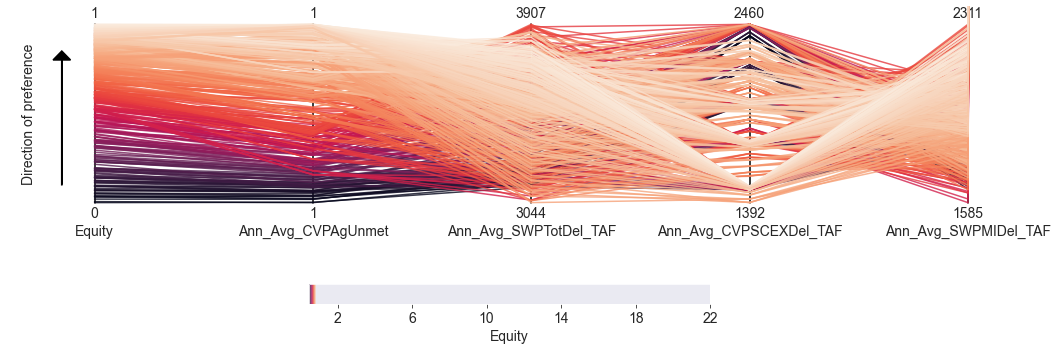

In [48]:
custom_parallel_coordinates(non_prob_metrics, columns_axes=non_prob_metrics.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

In [49]:
non_prob_metrics["Equity"].min(), non_prob_metrics["Equity"].max(), non_prob_metrics["Ann_Avg_CVPAgUnmet"].min(), non_prob_metrics["Ann_Avg_CVPAgUnmet"].max()

(0.441788056, 0.849610372, 0.511621714, 0.845358084)

First Notes: 
1) ANN_Avg_CVPAgUnmet ranges from 0.5116 to 0.845 but the graph is 1 to 1. Equity ranges from 0.441 to 0.849 but is represented from 0 to 1.
2) Only 5 parameters are plotted, though theoretically all of them should according to the function code.
3) 600 is too many to understand anything.
4) First column legend? Also colors are nonsensical.

Change: multiply equity and CVOAgUnmet by 100.

In [50]:
non_prob_metrics["Equity"] = non_prob_metrics["Equity"] * 100
non_prob_metrics["Ann_Avg_CVPAgUnmet"] = non_prob_metrics["Ann_Avg_CVPAgUnmet"] * 100
non_prob_metrics

,Equity,Ann_Avg_CVPAgUnmet,Ann_Avg_SWPTotDel_TAF,Ann_Avg_CVPSCEXDel_TAF,Ann_Avg_SWPMIDel_TAF,Ann_Avg_CVPRefDel_TAF,Ann_Avg_SWPAGDel_TAF,Sep_Avg_NODstorage_TAF,Apr_Avg_NODstorage_TAF,Apr_Avg_ShstaStorage_TAF,Apr_Avg_OrovlStorage_TAF,Ann_Avg_NDO_TAF,Fall_Avg_X2_KM,Spring_Avg_X2_KM,Ann_Avg_CVPTotDel_TAF,Ann_Avg_CVPAgDel_TAF,Ann_Avg_BanksJones_TAF,Oct_StDev_X2,Apr_StDev_X2
0,71.436065,71.265010,3450.959450,2459.309030,1757.988651,376.185582,1628.482302,6680.744502,9478.750280,4103.715194,2749.799326,15444.33174,-85.618250,-61.806239,2186.902364,1460.060352,5314.467080,6.542445,10.346875
1,73.604925,74.276226,3499.658107,2459.632700,1799.105249,376.210216,1636.064364,6885.186129,9395.367171,4137.956748,2625.274924,15791.11813,-85.734801,-61.499069,2628.024274,1625.425898,5221.043788,6.414817,10.206163
2,69.041709,70.555809,3373.532604,2457.731819,1744.720975,376.240630,1564.325251,5736.111245,8038.145646,3592.731022,2176.265243,16972.32263,-85.941630,-60.317475,4814.926628,1426.223396,5033.508183,5.933861,9.572897
3,58.435308,61.206463,3302.689714,2442.197441,1731.348519,374.308095,1506.898363,4249.038200,6402.984684,2763.109577,1829.999037,18013.57777,-85.995324,-59.398004,2192.581719,932.899995,4691.966771,5.909413,9.231497
4,47.956996,53.387420,3170.088090,2391.434551,1678.806572,367.869906,1427.022581,2507.414995,4469.111422,1788.753759,1440.410153,19001.69792,-85.959160,-58.437343,2793.895111,544.774300,4390.240189,5.926163,8.921624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,84.588303,84.332285,3749.019467,1487.738621,2209.963760,345.526543,1474.555824,8391.059538,10234.135410,4311.418024,3117.629656,16915.88986,-86.931424,-60.679017,2769.760738,1293.262583,5732.779077,8.176955,10.292074
596,84.711615,84.443095,3775.169014,1488.675061,2226.962577,346.987849,1483.706550,8425.503711,10155.360060,4325.283749,3030.763623,17339.84007,-87.648533,-59.966835,4714.616267,1295.765082,5408.148462,7.965440,9.747449
597,83.821643,84.469977,3679.903481,1489.617170,2167.232442,345.690186,1448.171156,7807.411624,9357.009617,4075.342370,2699.703011,18100.59199,-90.075829,-58.924593,1567.808950,1295.850483,5244.083322,5.983565,9.091666
598,82.129877,84.290969,3503.921800,1486.609654,2066.985002,344.473002,1372.436915,6919.194729,8432.144576,3757.659029,2321.739397,18769.05039,-91.584604,-58.156809,2581.599994,1293.155902,5049.943525,5.058976,8.797966


/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1174901976.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


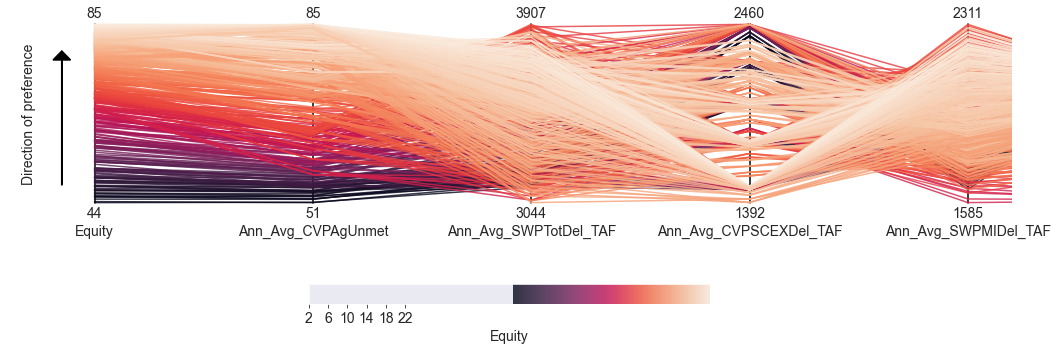

In [66]:
custom_parallel_coordinates(non_prob_metrics, columns_axes=non_prob_metrics.columns, axis_labels = non_prob_metrics.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', 'max','max','max','max','max',
                                     'max', 'max','max','max','max','max','max', 'max', 'max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

Change: ax.set_xlim changed to account for length of column.
NOTE: minmaxs parameter controls the plotting of parallel lines 

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1028638411.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


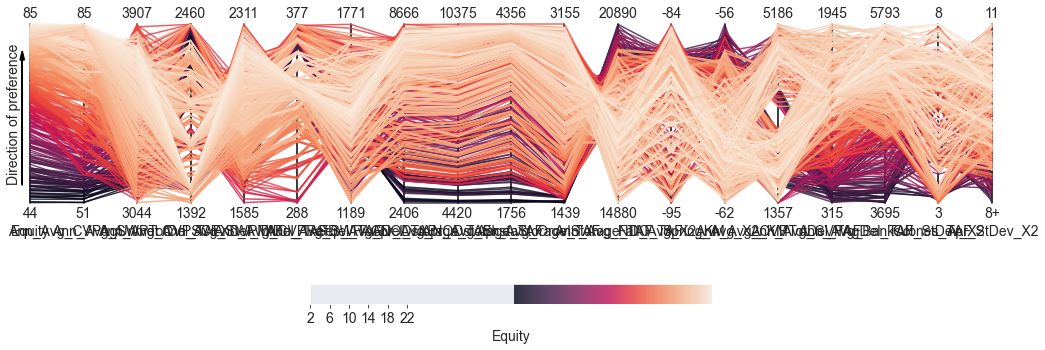

In [69]:
custom_parallel_coordinates(non_prob_metrics, columns_axes=non_prob_metrics.columns, axis_labels = non_prob_metrics.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', 'max','max','max','max','max',
                                     'max', 'max','max','max','max','max','max', 'max', 'max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

19 Variables in the figure seems too much, especially with our variable names being long. Let's try 7

In [77]:
non_prob_metrics_7 = non_prob_metrics.iloc[:, :7]

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1028638411.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


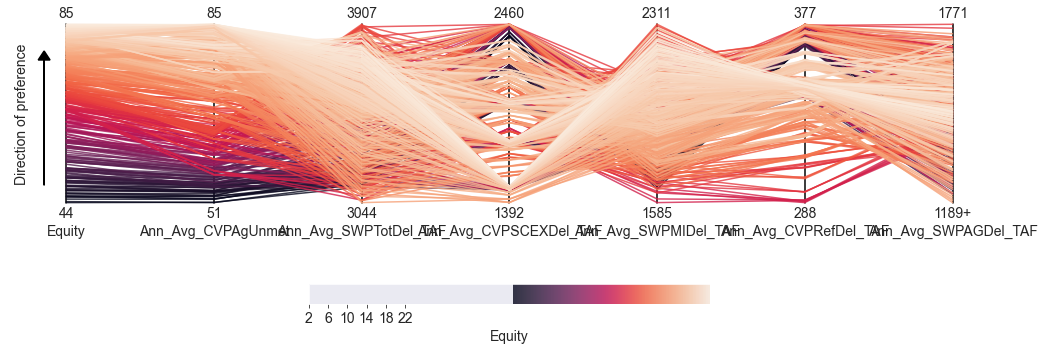

In [79]:
custom_parallel_coordinates(non_prob_metrics_7, columns_axes=non_prob_metrics_7.columns, axis_labels = non_prob_metrics_7.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max','max','max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

This figsize is better? Stretched a bit vertically.

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1028638411.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


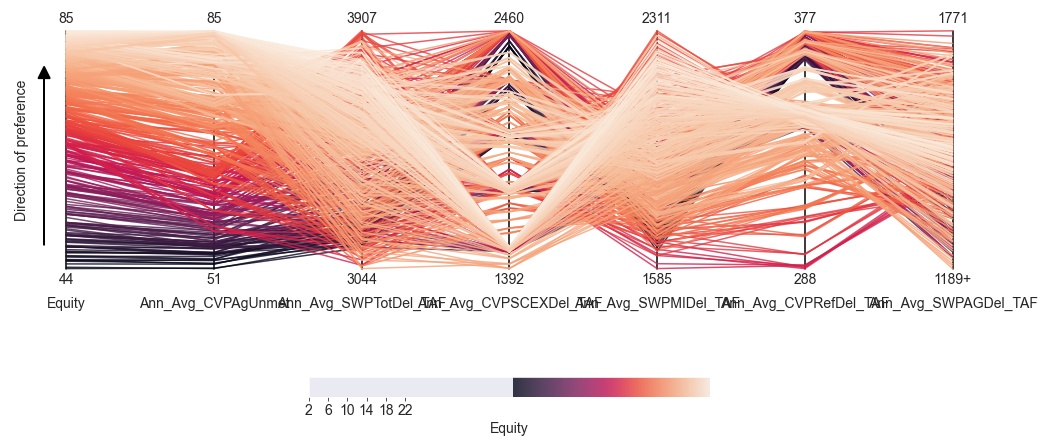

In [81]:
custom_parallel_coordinates(non_prob_metrics_7, columns_axes=non_prob_metrics_7.columns, axis_labels = non_prob_metrics_7.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=(18, 8),
                            minmaxs=['max','max','max','max','max','max','max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

Let's see how many scenarios are eliminated by setting (let's say means) goals.

In [86]:
equity_mean = non_prob_metrics["Equity"].mean()
cvpagunmet_mean = non_prob_metrics["Ann_Avg_CVPAgUnmet"].mean()
swptotdel_mean = non_prob_metrics["Ann_Avg_SWPTotDel_TAF"].mean()
cvpscex_mean = non_prob_metrics["Ann_Avg_CVPSCEXDel_TAF"].mean()
swpmi_mean = non_prob_metrics["Ann_Avg_SWPMIDel_TAF"].mean()

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1028638411.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


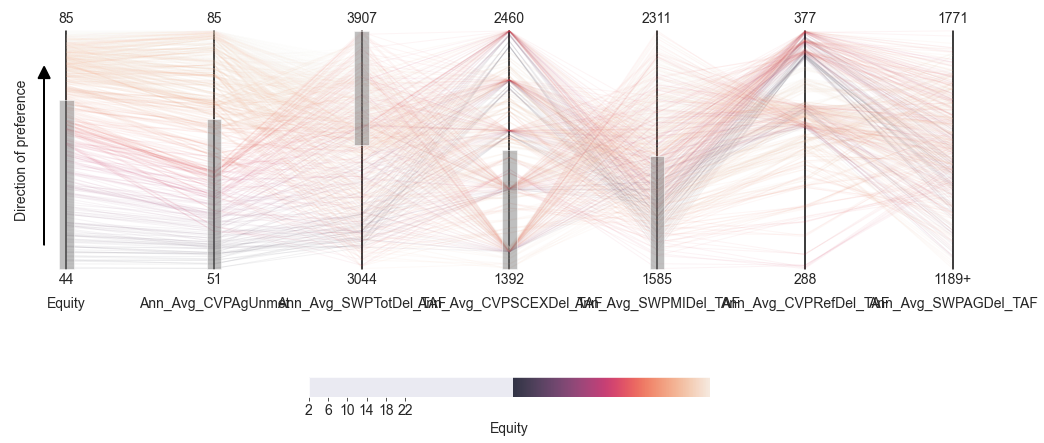

In [87]:
custom_parallel_coordinates(non_prob_metrics_7, columns_axes=non_prob_metrics_7.columns, axis_labels = non_prob_metrics_7.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=(18, 8),
                            minmaxs=['max','max','max','max','max','max','max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            brushing_dict = {0: (equity_mean, '>='), 1: (cvpagunmet_mean, '>='), 2: (swptotdel_mean, '<'),
                                             3: (cvpscex_mean, '>='), 4: (swpmi_mean, '>='),},
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

oops none of them, let me try some random values

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_4265/1028638411.py:166: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,


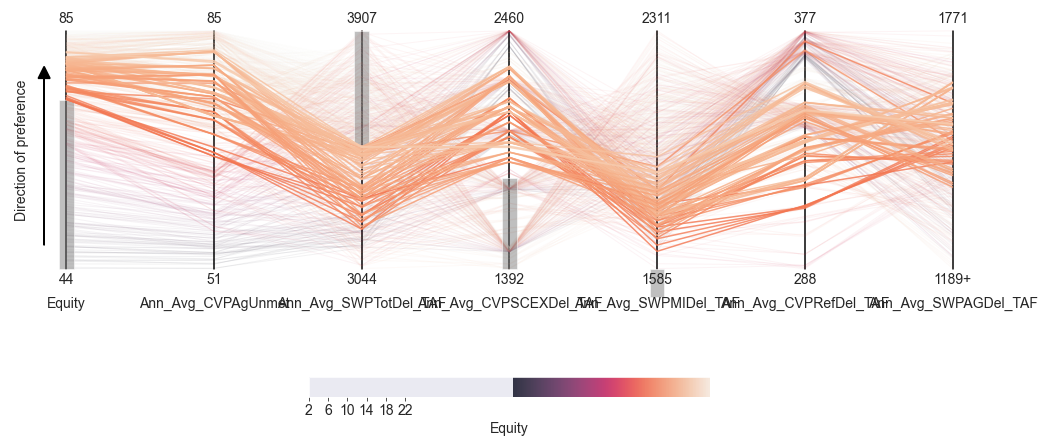

In [91]:
custom_parallel_coordinates(non_prob_metrics_7, columns_axes=non_prob_metrics_7.columns, axis_labels = non_prob_metrics_7.columns,
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=(18, 8),
                            minmaxs=['max','max','max','max','max','max','max'],
                            colorbar_ticks_continuous=range(2,25,4),
                            brushing_dict = {0: (equity_mean, '>='), 2: (swptotdel_mean, '<'),
                                             3: (1800, '>='), 4: (1500, '>='),},
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

Note, we do not see which simulations which satisfy these criteria, so it would be beneficial to add a function that filters the metrics dataframe too.